# This notebook is to extract the groove's surface 
- This notebook was used for defining Pol 1a P1 site as an example case
- This notebook contains detailed explanation of the functions

- The identified sites were dealt with as pockets of unique nature, hence referred to as pocket or groove throughout the code 

## 1.0 Libraries

In [ ]:
# import the site identification module from fibrilsite 
from fibrilsite.site_identification import *

## 2.0 I/O

In [ ]:
# pocket id
pocket_id = 'Pol_1a_P1'

# start res info – residue at one edge of the site to be defined
start_resid = 85
start_atom  = 'HB1'
    
# end res info – residue at the other edge of the site to be defined
end_resid = 97
end_atom  = 'HZ1'

# Guard res info – residues at the outer sides that will be used to govern the site surface isolation
guard_start_resid = 83
guard_start_atom  = 'C'

guard_end_resid   = 97
guard_end_atom    = 'O'

# groove segmentation – definine the site forming residue ids and chains
start_groove_chains = ['I', 'G', 'C', 'E', 'A']
end_groove_chains   = ['I', 'G', 'C', 'E', 'A']

start_groove_resids = [85,86,87,90,92,95,97,]
end_groove_resids   = [85,86,87,90,92,95,97,]

# assign variables – define paths to the fibril pdb file and MaSIF generated ply file 
pdb_file = "../pdbs/6cu7_ABCDEFGHIJ.pdb"
ply_file = "../plys/6cu7_ABCDEFGHIJ.ply"

# struct chains
parser = PDBParser(QUIET=1)
struct = parser.get_structure(os.path.basename(pdb_file).split('_')[0], pdb_file)[0]
chains = [chain.id for chain in struct]

In [3]:
# make output dir
output = f'../sel_fibril_sites/{datetime.date.today()}_{os.path.basename(pdb_file).split("_")[0]}_{pocket_id}/'
os.makedirs(output, exist_ok=0)

In [4]:
# Data file output
with open(f"{output}/{datetime.date.today()}_{os.path.basename(pdb_file).replace('.pdb','')}_{pocket_id}_params.txt",'w') as w:
    w.write(f'{datetime.date.today()}' + '\n')
    w.write(f'Pocket id: {pocket_id}' + '\n')
    w.write(f'PDB file: {pdb_file}'  + '\n')
    w.write(f'PLY file: {ply_file}'  + '\n')
    w.write(f'Start resid: {start_resid}, Start atom: {start_atom}' + '\n')
    w.write(f'End resid: {end_resid}, End atom: {end_atom}' + '\n')
    w.write(f'Guard start resid: {guard_start_resid}, Guard start atom: {guard_start_atom}' + '\n')
    w.write(f'Guard end resid: {guard_end_resid}, Guard end atom: {guard_end_atom}' + '\n')
    w.write(f'Start groove chains: {start_groove_chains}, Start groove resids: {start_groove_resids}' + '\n')
    w.write(f'End groove chains: {end_groove_chains}, End groove resids: {end_groove_resids}' + '\n')
print('Gedruckt')

Gedruckt


## 3.0 Parse

In [ ]:
# Parse pdbs and calculate per atom sasa
## Here we parse the fibril pdb file and calculate per residue SASA

df_atom_sasa = pdb_parser_and_per_atom_sasa_calculator(
    out_path=output,
    pdb_file=pdb_file,
    probe_r=1.4,
)
print(df_atom_sasa.shape)
df_atom_sasa.head()

(8530, 6)


,chain,resid,resname,atom_type,coords,sasa
0,E,38,LEU,N,"[-28.784, -20.335, 8.294]",0.0
1,E,38,LEU,CA,"[-29.006, -20.181, 9.717]",0.0
2,E,38,LEU,C,"[-29.191, -21.54, 10.375]",0.0
3,E,38,LEU,O,"[-29.729, -21.641, 11.476]",0.0
4,E,38,LEU,CB,"[-30.202, -19.253, 9.969]",0.0


In [ ]:
# parse ply file
## Here we parse the fibril generated MaSIF ply file

df_surf = ply_parser(out_path=output, 
                     ply_file=ply_file,
                    )
print(df_surf.shape)
df_surf.head()

(10543, 6)


,MaSIF_index,surf_coords,surf_charge,surf_hbond,surf_hphob,surf_normals
0,0,"[-33.053, -26.353, 9.274]",0.334680,0.000000,-1.3,"[-0.19912, -0.971995, -0.124807]"
1,1,"[8.717, -28.806, 24.182]",-0.487031,-0.000000,1.8,"[-0.799462, -0.467497, 0.377235]"
2,2,"[25.706, -1.604, 14.155]",4.591000,0.000000,-3.9,"[0.692516, 0.53526, -0.483651]"
3,3,"[-6.87, -18.637, 21.247]",0.480772,0.457984,-3.5,"[0.0700317, 0.218916, 0.973227]"
4,4,"[-6.367, -5.677, 23.577]",-0.422399,0.000000,-0.4,"[-0.194886, -0.437104, 0.878043]"


## 4.0 Get the main vectors

In [ ]:
# Here we calculate eignenvectors to define the main fibril axis
side, perpend, major = calculate_eigenvectors(pdb_file=pdb_file, 
                                              anchor_residues=[53,], 
                                              anchor_chains= start_groove_chains
                                             )

fibril_axis = np.array(major)
print(f"fibril elongation axis {major}")

fibril elongation axis [ 0.0068998   0.00319991 -0.9999711 ]


In [ ]:
# Visualize the major vector
vector_xyz_writer(out_path=output, 
                  file_name='major_eigenvector', 
                  vector=fibril_axis,  
                  element='C',)

'GO SEE!'

## 5.0 Isolate the pocket surface

In [ ]:
# Here we isolate the fibril side surface and remove the top and bottom surfaces 
# through the calculated dot product between the fibril elongation axis and the surface points normals

df_side_surf = isolate_fibril_side(
    out_path=output,
    pdb_file=pdb_file,
    df=df_surf,
    fibril_axis=fibril_axis,
)
print(df_side_surf.shape)
df_side_surf.head()

(3888, 7)


,MaSIF_index,surf_coords,surf_charge,surf_hbond,surf_hphob,surf_normals,surf_norm_fibril_dot
0,0,"[-33.053, -26.353, 9.274]",0.334680,0.0,-1.3,"[-0.19912, -0.971995, -0.124807]",0.120319
1,5,"[-11.221, -37.249, 2.479]",-0.857072,0.0,-3.5,"[0.401304, -0.868204, 0.291851]",-0.291852
2,18,"[4.245, -28.252, 3.347]",1.904720,0.0,-0.8,"[0.260355, -0.925229, 0.275983]",-0.277139
3,19,"[26.195, 26.506, 19.8915]",0.473371,0.0,4.2,"[0.295042, 0.941011, -0.165674]",0.170716
4,22,"[0.2005, -32.4705, 0.9155]",0.093913,0.0,1.8,"[0.957718, 0.0289633, -0.286248]",0.292940


In [ ]:
# Visualize the isolated fibril side surface
pymol_xyz_writer(
    out_path=output,
    file_name="side_surface_points",
    df=df_side_surf,
    coords_column="surf_coords",
    element="C",
)

'GO SEE!'

In [ ]:
# Here we isolate the pocket (site) atomic coordinates 
# using the fibril pdb file, defined site-forming residue ids, and chains

df_pocket_coords = pocket_getter(
    df=df_atom_sasa,
    pocket_name=pocket_id,
    pdb_file=pdb_file,
    out_path=output,
    sym=False,
    chains_asym_1=start_groove_chains,
    chains_asym_1_resids=start_groove_resids,
    chains_asym_2=end_groove_chains,
    chains_asym_2_resids=end_groove_resids,
)
print(df_pocket_coords.shape)
df_pocket_coords.head()

(450, 6)


,chain,resid,resname,atom_type,coords,sasa
0,E,85,ALA,N,"[-4.352, -32.786, 10.675]",0.00
1,E,85,ALA,CA,"[-3.315, -32.232, 11.533]",0.00
2,E,85,ALA,C,"[-2.723, -30.999, 10.871]",0.00
3,E,85,ALA,O,"[-1.918, -31.114, 9.943]",5.36
4,E,85,ALA,CB,"[-2.238, -33.278, 11.794]",7.25


In [ ]:
# Write out the pocket coords
with open(f"{output}/pocket_coods.xyz", "w") as w:
    for coords in df_pocket_coords['coords']:
        coords = coords.tolist()
        w.write(f'C {coords[0]} {coords[1]} {coords[2]} \n')

In [ ]:
# Here we isolate the desired pocket (site) surface 
# through mapping the isolated pocket coordinates (from the pdb file)
# to the nearest neighbours in the generated surface points (from the ply file)

df_pocket_surf = surface_atomic_coords_mapper(
    out_path=output,
    df_surf=df_side_surf,
    df_atomic=df_pocket_coords,
    threshold=3.0,
    pdb_file=pdb_file,
)
print(df_pocket_surf.shape)
df_pocket_surf.head()

(382, 13)


,chain,resid,resname,atom_type,coords,sasa,MaSIF_index,surf_coords,surf_charge,surf_hbond,surf_hphob,surf_normals,surf_norm_fibril_dot
0,E,85,ALA,N,"[-4.352, -32.786, 10.675]",0.00,5077,"[-5.2845, -34.3737, 10.665]",0.919082,0.000000,1.17782,"[0.0935373, -0.978713, 0.182677]",-0.185158
1,E,85,ALA,CA,"[-3.315, -32.232, 11.533]",0.00,1743,"[-4.549, -33.633, 12.625]",0.700611,0.000000,1.80000,"[-0.201331, -0.977956, 0.05538]",-0.059897
2,E,85,ALA,C,"[-2.723, -30.999, 10.871]",0.00,4839,"[-0.913, -31.873, 11.2098]",0.294057,-0.005686,1.80000,"[0.998504, 0.0462843, 0.0291052]",-0.022067
3,E,85,ALA,O,"[-1.918, -31.114, 9.943]",5.36,3066,"[-0.597, -30.763, 10.244]",-0.568392,-0.000000,1.80000,"[0.955121, -0.274045, 0.112439]",-0.106723
4,E,85,ALA,CB,"[-2.238, -33.278, 11.794]",7.25,9578,"[-0.649375, -33.6351, 12.3311]",0.508585,0.000000,1.80000,"[0.898844, -0.394701, 0.190503]",-0.185559


In [ ]:
# Visualize the pocket surface
pymol_xyz_writer(
    out_path=output,
    file_name=f"{pocket_id}_pocket_surface",
    df=df_pocket_surf,
    coords_column="surf_coords",
    element="C",
)

'GO SEE!'

## 6.0 Expand to get all surface points

In [ ]:
# Here we isolate the pocket (site) full surface
# through using the previously mapped surface points as anchors
# and including neighbouring surface points within a certain threshold

df_full_pocket = the_groove_expander(
    df_pocket_surf=df_pocket_surf,
    df_atom_sasa=df_atom_sasa,
    df_side_surf=df_side_surf,
    pdb_file=pdb_file,
    out_path=output,
    pocket_name=pocket_id,
    threshold=3.0,
)
df_full_pocket.head()

(575, 14)


/home/asadek/miniconda3/envs/masif/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals
0,5077,N,E,"[-4.352, -32.786, 10.675]",NaN,85.0,ALA,0.00,0.919082,"[-5.2845, -34.3737, 10.665]",0.000000,1.17782,-0.185158,"[0.0935373, -0.978713, 0.182677]"
1,1743,CA,E,"[-3.315, -32.232, 11.533]",NaN,85.0,ALA,0.00,0.700611,"[-4.549, -33.633, 12.625]",0.000000,1.80000,-0.059897,"[-0.201331, -0.977956, 0.05538]"
2,4839,C,E,"[-2.723, -30.999, 10.871]",NaN,85.0,ALA,0.00,0.294057,"[-0.913, -31.873, 11.2098]",-0.005686,1.80000,-0.022067,"[0.998504, 0.0462843, 0.0291052]"
3,3066,O,E,"[-1.918, -31.114, 9.943]",NaN,85.0,ALA,5.36,-0.568392,"[-0.597, -30.763, 10.244]",-0.000000,1.80000,-0.106723,"[0.955121, -0.274045, 0.112439]"
4,9578,CB,E,"[-2.238, -33.278, 11.794]",NaN,85.0,ALA,7.25,0.508585,"[-0.649375, -33.6351, 12.3311]",0.000000,1.80000,-0.185559,"[0.898844, -0.394701, 0.190503]"


In [ ]:
# Visualise the expanded pocket
pymol_xyz_writer(
    out_path=output,
    file_name="extended_pocket_surf",
    df=df_full_pocket,
    coords_column="surf_coords",
    element="C",
)

'GO SEE!'

## 7.0 Clean up the rims 

In [ ]:
# Identify the surface points to remove from the starting end of the pocket (site)
# this is achieved involving the guard residues and a distance threshold that set following manual inspection 

df_start_rim = pocket_rim_cleaner(df_atom_sasa=df_atom_sasa, df_full_pocket=df_full_pocket, 
                                        pocket_chains=start_groove_chains, res_resid=start_resid, res_atom=start_atom,
                                        guard_resid=guard_start_resid, guard_atom=guard_start_atom, 
                                        threshold=5.0, pdb_file=pdb_file, outpath=output)
df_start_rim.head()

(70, 16)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals,dist_from_guard,dist_from_start
308,4111,N,G,"[11.462, -28.222, 17.763]",NaN,92.0,THR,0.00,0.706704,"[-6.44, -34.2615, 20.2768]",0.000000,1.17870,-0.193624,"[0.108904, -0.975479, 0.191259]",3.267280,5.262441
313,5336,OG1,G,"[11.85, -31.896, 18.057]",NaN,92.0,THR,1.07,0.950870,"[-5.63475, -34.3015, 19.168]",0.470444,1.05183,0.257164,"[0.0391569, -0.964817, -0.259989]",4.287431,5.021805
514,5944,NaN,NaN,NaN,0.673276,NaN,NaN,NaN,0.703565,"[-6.28687, -33.7455, 18.0252]",0.000000,-0.40000,0.147226,"[0.334565, -0.930694, -0.1479]",4.184164,6.096873
521,4317,NaN,NaN,NaN,0.752389,NaN,NaN,NaN,-0.161811,"[-7.4665, -34.6867, 17.985]",-0.060485,-3.50000,-0.179510,"[0.420987, -0.889114, 0.179575]",3.651059,7.230563
522,6675,NaN,NaN,NaN,0.849634,NaN,NaN,NaN,0.327120,"[-7.14738, -34.6629, 18.9519]",0.000000,-0.40000,0.116515,"[0.243624, -0.962675, -0.117918]",3.239552,6.486513


In [ ]:
# Identify the surface points to remove from the other end of the pocket (site)
# this is achieved involving the guard residues and a distance threshold that set following manual inspection 

df_end_rim = pocket_rim_cleaner(df_atom_sasa=df_atom_sasa, df_full_pocket=df_full_pocket, 
                                        pocket_chains=end_groove_chains, res_resid=end_resid, res_atom=end_atom,
                                        guard_resid=guard_end_resid, guard_atom=guard_end_atom, 
                                        threshold=6.0, pdb_file=pdb_file, outpath=output)
df_end_rim.head()

(182, 16)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals,dist_from_guard,dist_from_start
286,7330,HA3,G,"[-3.68, -27.963, 15.633]",NaN,86.0,GLY,0.0,-0.091277,"[15.6679, -43.9502, 19.6713]",0.218457,-3.9,-0.086246,"[0.985289, 0.143044, 0.0935051]",2.726133,9.849388
287,369,N,G,"[-1.071, -27.204, 15.973]",NaN,87.0,SER,0.0,-0.572764,"[13.7837, -45.4987, 19.2085]",0.000000,-3.9,-0.186211,"[-0.310334, -0.93322, 0.181089]",3.273325,8.703948
288,2841,CA,G,"[0.08, -26.656, 16.67]",NaN,87.0,SER,0.0,-17.997200,"[15.188, -47.08, 17.454]",0.000000,-3.9,-0.046464,"[-0.0443081, -0.998094, 0.0429656]",4.650522,11.158495
289,1555,C,G,"[0.44, -25.308, 16.074]",NaN,87.0,SER,0.0,-0.767968,"[17.535, -46.321, 16.796]",-0.991560,-3.9,0.232395,"[0.759567, -0.608742, -0.229109]",5.393942,13.069878
290,2861,O,G,"[0.022, -24.968, 14.966]",NaN,87.0,SER,0.0,0.186333,"[12.3749, -46.1406, 17.3484]",0.000000,-3.9,0.102597,"[-0.326499, -0.939023, -0.107858]",5.629706,8.616462


In [ ]:
# Isolate the pocket from the rim points

idx_to_drop = set(df_start_rim.index.tolist() + df_end_rim.index.to_list())

df_pocket_isolate = df_full_pocket.copy()
df_pocket_isolate = df_pocket_isolate[~df_pocket_isolate.index.isin(idx_to_drop)]
df_pocket_isolate.drop_duplicates(subset='MaSIF_index', inplace=True) # remove duplicated points based on MaSIF idx
df_pocket_isolate.reset_index(drop=True, inplace=True)

# export
df_pocket_isolate.to_csv(f'{output}/{datetime.date.today()}_{os.path.basename(pdb_file).split("_")[0]}_{pocket_id}_isolate.csv')

print(df_pocket_isolate.shape)
df_pocket_isolate.head()

(334, 14)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals
0,4839,C,E,"[-2.723, -30.999, 10.871]",NaN,85.0,ALA,0.00,0.294057,"[-0.913, -31.873, 11.2098]",-0.005686,1.8,-0.022067,"[0.998504, 0.0462843, 0.0291052]"
1,3066,O,E,"[-1.918, -31.114, 9.943]",NaN,85.0,ALA,5.36,-0.568392,"[-0.597, -30.763, 10.244]",-0.000000,1.8,-0.106723,"[0.955121, -0.274045, 0.112439]"
2,9578,CB,E,"[-2.238, -33.278, 11.794]",NaN,85.0,ALA,7.25,0.508585,"[-0.649375, -33.6351, 12.3311]",0.000000,1.8,-0.185559,"[0.898844, -0.394701, 0.190503]"
3,5811,HB2,E,"[-2.634, -34.049, 12.23]",NaN,85.0,ALA,12.74,0.493869,"[-2.84238, -35.0911, 12.0895]",0.000000,1.8,-0.121154,"[-0.0925209, -0.988771, 0.117355]"
4,8883,HB3,E,"[-1.842, -33.552, 10.952]",NaN,85.0,ALA,7.65,0.545860,"[-1.60563, -34.725, 11.049]",0.000000,1.8,0.162611,"[0.404138, -0.90011, -0.162708]"


In [ ]:
# Write out the isolated pocket surface points for visualization
pymol_xyz_writer(
    out_path=output,
    file_name="isolated_pocket",
    df=df_pocket_isolate,
    coords_column="surf_coords",
    element="C",
)

'GO SEE!'

## 8.0 Manual filtering
- Here we remove points in the proximity of a certain residue to ensure that the defined pocket (site) does not contain other surface points that can interfere with the alignments in the next step
- This step leads to a refined pocket (site)
- This step is not usually needed, hence in some cases the final version of the pocket (site) is the "isolated" version

In [21]:
df_pocket_refined = filter_by_range(
    df_atom_sasa=df_atom_sasa,
    df_pocket_isolate=df_pocket_isolate,
    resid=91,
    chain="I",
    atom="CB",
    output=output,
    pocket_id=pocket_id,
    pdb_file=pdb_file,
    dist_thresh=5.0,
)
df_pocket_refined.head()

(9, 16)
(325, 14)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals
0,4839,C,E,"[-2.723, -30.999, 10.871]",NaN,85.0,ALA,0.00,0.294057,"[-0.913, -31.873, 11.2098]",-0.005686,1.8,-0.022067,"[0.998504, 0.0462843, 0.0291052]"
1,3066,O,E,"[-1.918, -31.114, 9.943]",NaN,85.0,ALA,5.36,-0.568392,"[-0.597, -30.763, 10.244]",-0.000000,1.8,-0.106723,"[0.955121, -0.274045, 0.112439]"
2,9578,CB,E,"[-2.238, -33.278, 11.794]",NaN,85.0,ALA,7.25,0.508585,"[-0.649375, -33.6351, 12.3311]",0.000000,1.8,-0.185559,"[0.898844, -0.394701, 0.190503]"
3,5811,HB2,E,"[-2.634, -34.049, 12.23]",NaN,85.0,ALA,12.74,0.493869,"[-2.84238, -35.0911, 12.0895]",0.000000,1.8,-0.121154,"[-0.0925209, -0.988771, 0.117355]"
4,8883,HB3,E,"[-1.842, -33.552, 10.952]",NaN,85.0,ALA,7.65,0.545860,"[-1.60563, -34.725, 11.049]",0.000000,1.8,0.162611,"[0.404138, -0.90011, -0.162708]"


In [22]:
df_pocket_refined = filter_by_range(
    df_atom_sasa=df_atom_sasa,
    df_pocket_isolate=df_pocket_refined,
    resid=89,
    chain="I",
    atom="O",
    output=output,
    pocket_id=pocket_id,
    pdb_file=pdb_file,
    dist_thresh=5.0,
)
df_pocket_refined.head()

(2, 16)
(323, 14)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,surf_hbond,surf_hphob,surf_norm_fibril_dot,surf_normals
0,4839,C,E,"[-2.723, -30.999, 10.871]",NaN,85.0,ALA,0.00,0.294057,"[-0.913, -31.873, 11.2098]",-0.005686,1.8,-0.022067,"[0.998504, 0.0462843, 0.0291052]"
1,3066,O,E,"[-1.918, -31.114, 9.943]",NaN,85.0,ALA,5.36,-0.568392,"[-0.597, -30.763, 10.244]",-0.000000,1.8,-0.106723,"[0.955121, -0.274045, 0.112439]"
2,9578,CB,E,"[-2.238, -33.278, 11.794]",NaN,85.0,ALA,7.25,0.508585,"[-0.649375, -33.6351, 12.3311]",0.000000,1.8,-0.185559,"[0.898844, -0.394701, 0.190503]"
3,5811,HB2,E,"[-2.634, -34.049, 12.23]",NaN,85.0,ALA,12.74,0.493869,"[-2.84238, -35.0911, 12.0895]",0.000000,1.8,-0.121154,"[-0.0925209, -0.988771, 0.117355]"
4,8883,HB3,E,"[-1.842, -33.552, 10.952]",NaN,85.0,ALA,7.65,0.545860,"[-1.60563, -34.725, 11.049]",0.000000,1.8,0.162611,"[0.404138, -0.90011, -0.162708]"


In [ ]:
# Write out the refined pocket surface points for visualization
pymol_xyz_writer(
    out_path=output,
    file_name="refined_pocket",
    df=df_pocket_refined,
    coords_column="surf_coords",
    element="C",
)

'GO SEE!'

## 9.0 Calculate the area and volume

In [ ]:
# Calculate the pocket (site) area from calculated SASA
total_sasa, pocket_hphob_sasa, percent_hphob = get_areas(df=df_pocket_coords)

In [ ]:
# Get the pocket (site) surface coordinates x,y,z

# Map df to the latest stage of pocket form
try:
    df_pocket_refined
except NameError:
    df = df_pocket_isolate.copy()
else:
    df = df_pocket_refined.copy()


df['vertex_x'] = df['surf_coords'].apply(lambda x: float(x[0]))
df['vertex_y'] = df['surf_coords'].apply(lambda x: float(x[1]))
df['vertex_z'] = df['surf_coords'].apply(lambda x: float(x[2]))

# get the coords
mesh_verts = np.stack((df.vertex_x.to_numpy(),
                      df.vertex_y.to_numpy(),
                       df.vertex_z.to_numpy()), axis=1)
mesh_verts.shape

(323, 3)

### 9.1 Create convex hull

In [26]:
# Create the convexhull
pocket_hull = ConvexHull(points=mesh_verts,)

print(f'pocket area: {pocket_hull.area}')
print(f'pocket volume: {pocket_hull.volume}')

pocket area: 1380.9040448790684
pocket volume: 3818.23026829706


DEBUG - 2025-04-08 09:57:20,464 - font_manager - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG - 2025-04-08 09:57:20,467 - font_manager - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
DEBUG - 2025-04-08 09:57:20,467 - font_manager - findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG - 2025-04-08 09:57:20,468 - font_manager - findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG - 2025-04-08 09:57:20,468 - font_manager - findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG - 2025-04-08 09:57:20,468 - font_manager - findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
DEBUG - 2025-04-08 09:57:20,469 - font_manager - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>

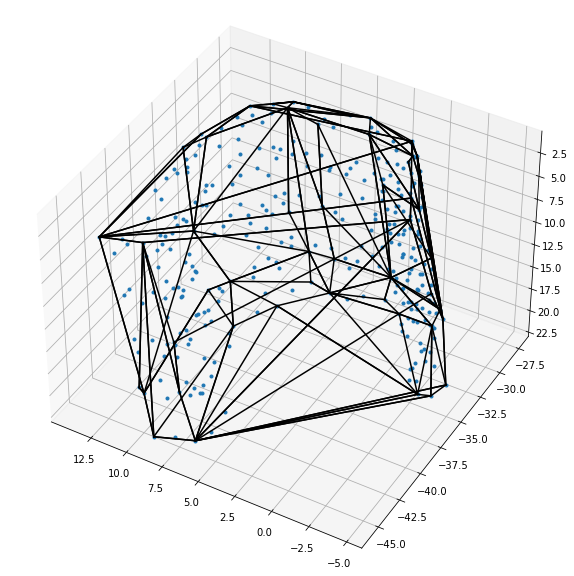

In [ ]:
# Visualise
fig = plt.figure(figsize=(10,15), clear=True)
ax = plt.axes(projection='3d')

ax.view_init(-140, 60)
ax.plot3D(mesh_verts[:,0], mesh_verts[:,1],mesh_verts[:,2], '.')

for simplex in pocket_hull.simplices:
    ax.plot3D(mesh_verts[simplex, 0], mesh_verts[simplex, 1], mesh_verts[simplex,2], 'k-')

plt.savefig(f"{output}/{datetime.date.today()}_{pocket_id}_pocket_and_hull.png", format="png" ,dpi=300, transparent=True)

### 9.2 Export hull with PyMesh

In [ ]:
# Create a mesh for the defined pocket (site)
mesh = pymesh.form_mesh(pocket_hull.points, pocket_hull.simplices) 

In [ ]:
# Get the surface normals (nx, ny, nz) for the defined pocket (site)
df['vertex_nx'] = df['surf_normals'].apply(lambda x: float(x[0]))
df['vertex_ny'] = df['surf_normals'].apply(lambda x: float(x[1]))
df['vertex_nz'] = df['surf_normals'].apply(lambda x: float(x[2]))

# Format the other parameters to be added to the mesh
df['vertex_charge'] = df['surf_charge'].apply(lambda x: float(x))
df['vertex_hbond']  = df['surf_hbond'].apply(lambda x: float(x))
df['vertex_hphob']  = df['surf_hphob'].apply(lambda x: float(x))

# export
df.to_csv(f'{output}/{datetime.date.today()}_pocket_expanded_for_mesh.csv')

print(df.shape)
df.head()

(323, 23)


,MaSIF_index,atom_type,chain,coords,point_direction,resid,resname,sasa,surf_charge,surf_coords,...,surf_normals,vertex_x,vertex_y,vertex_z,vertex_nx,vertex_ny,vertex_nz,vertex_charge,vertex_hbond,vertex_hphob
0,4839,C,E,"[-2.723, -30.999, 10.871]",NaN,85.0,ALA,0.00,0.294057,"[-0.913, -31.873, 11.2098]",...,"[0.998504, 0.0462843, 0.0291052]",-0.913000,-31.8730,11.2098,0.998504,0.046284,0.029105,0.294057,-0.005686,1.8
1,3066,O,E,"[-1.918, -31.114, 9.943]",NaN,85.0,ALA,5.36,-0.568392,"[-0.597, -30.763, 10.244]",...,"[0.955121, -0.274045, 0.112439]",-0.597000,-30.7630,10.2440,0.955121,-0.274045,0.112439,-0.568392,-0.000000,1.8
2,9578,CB,E,"[-2.238, -33.278, 11.794]",NaN,85.0,ALA,7.25,0.508585,"[-0.649375, -33.6351, 12.3311]",...,"[0.898844, -0.394701, 0.190503]",-0.649375,-33.6351,12.3311,0.898844,-0.394701,0.190503,0.508585,0.000000,1.8
3,5811,HB2,E,"[-2.634, -34.049, 12.23]",NaN,85.0,ALA,12.74,0.493869,"[-2.84238, -35.0911, 12.0895]",...,"[-0.0925209, -0.988771, 0.117355]",-2.842380,-35.0911,12.0895,-0.092521,-0.988771,0.117355,0.493869,0.000000,1.8
4,8883,HB3,E,"[-1.842, -33.552, 10.952]",NaN,85.0,ALA,7.65,0.545860,"[-1.60563, -34.725, 11.049]",...,"[0.404138, -0.90011, -0.162708]",-1.605630,-34.7250,11.0490,0.404138,-0.900110,-0.162708,0.545860,0.000000,1.8


In [ ]:
# Get the mesh attributes as numpy arrays from the dataframe
vertex_nx       = df.vertex_nx.to_numpy()
vertex_ny       = df.vertex_ny.to_numpy()
vertex_nz       = df.vertex_nz.to_numpy()
vertex_charge   = df.vertex_charge.to_numpy()
vertex_hbond    = df.vertex_hbond.to_numpy()
vertex_hphob    = df.vertex_hphob.to_numpy()

# Add the attributes to the mesh
mesh.add_attribute('vertex_nx')
mesh.set_attribute('vertex_nx' , vertex_nx)

mesh.add_attribute('vertex_ny')
mesh.set_attribute('vertex_ny' , vertex_ny)

mesh.add_attribute('vertex_nz')
mesh.set_attribute('vertex_nz' , vertex_nz)

mesh.add_attribute('vertex_charge')
mesh.set_attribute('vertex_charge', vertex_charge)

mesh.add_attribute('vertex_hbond')
mesh.set_attribute('vertex_hbond', vertex_hbond)

mesh.add_attribute('vertex_hphob')
mesh.set_attribute('vertex_hphob', vertex_hphob)

# save mesh with attributes
pymesh.save_mesh(f'{output}/{pocket_id}_convex_hull.ply', mesh, *mesh.get_attribute_names() ,use_float=True, ascii=True)

## 10.0 Write out the pocket properties

In [ ]:
# Generate the pocket forming residue name/id sequence
pocket_resids = sorted(list(set(start_groove_resids+end_groove_resids)))
pocket_resnames  = list(df_atom_sasa[(df_atom_sasa.resid.isin(pocket_resids)) & (df_atom_sasa.atom_type == 'CA') & (df_atom_sasa.chain == start_groove_chains[0])]['resname'])
pocket_res_id_paired = ', '.join([f'{i} {r}' for i,r in zip(pocket_resids, pocket_resnames)])
pocket_res_id_paired

'85 ALA, 86 GLY, 87 SER, 90 ALA, 92 THR, 95 VAL, 97 LYS'

In [ ]:
# content container
prop_dic = {} 

prop_dic['fibril']                  = os.path.basename(pdb_file).split('_')[0]
prop_dic['pocket_id']               = pocket_id 
prop_dic['start_resid']             = start_resid
prop_dic['start_atom']              = start_atom
prop_dic['end_resid']               = end_resid
prop_dic['end_atom']                = end_atom
prop_dic['guard_start_resid']       = guard_start_resid
prop_dic['guard_start_atom']        = guard_start_atom
prop_dic['guard_end_resid']         = guard_end_resid
prop_dic['guard_end_atom']          = guard_end_atom
prop_dic['pocket_chains']           = [list(set(start_groove_chains+end_groove_chains))]
prop_dic['start_groove_chains']     = [start_groove_chains]
prop_dic['end_groove_chains']       = [end_groove_chains]
prop_dic['pocket_seq']              = pocket_res_id_paired
prop_dic['pocket_resids']           = [sorted(list(set(start_groove_resids+end_groove_resids)))]
prop_dic['start_groove_resids']     = [start_groove_resids]
prop_dic['end_groove_resids']       = [end_groove_resids]
prop_dic['pocket_res_num']          = len(set(start_groove_resids + end_groove_resids))
prop_dic['pocket_chain_num']        = len(set(start_groove_chains + end_groove_chains))
prop_dic['pocket_volume(A3)']       = round(pocket_hull.volume, 2)
prop_dic['pocket_area(A2)']         = total_sasa
prop_dic['pocket_hphob_area(A2)']   = pocket_hphob_sasa
prop_dic['pocket_hphob_area_%']     = percent_hphob

prop_dic

# put all information into a dataframe
prop_df = pd.DataFrame(prop_dic, index=[0])

# export
prop_df.to_csv(f'{output}/{datetime.date.today()}_{pocket_id}_params.csv')
prop_df

,fibril,pocket_id,start_resid,start_atom,end_resid,end_atom,guard_start_resid,guard_start_atom,guard_end_resid,guard_end_atom,...,pocket_seq,pocket_resids,start_groove_resids,end_groove_resids,pocket_res_num,pocket_chain_num,pocket_volume(A3),pocket_area(A2),pocket_hphob_area(A2),pocket_hphob_area_%
0,6cu7,Pol_1a_P1,85,HB1,97,HZ1,83,C,97,O,...,"85 ALA, 86 GLY, 87 SER, 90 ALA, 92 THR, 95 VAL, 97 LYS","[85, 86, 87, 90, 92, 95, 97]","[85, 86, 87, 90, 92, 95, 97]","[85, 86, 87, 90, 92, 95, 97]",7,5,3818.23,2029.89,799.69,39.4
